<a href="https://www.kaggle.com/code/hntrnnggia/bone-eda?scriptVersionId=230848928" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

file_path = "/kaggle/working/classification.xlsx"

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Đã xóa {file_path}")
else:
    print("Tệp không tồn tại!")

Tệp không tồn tại!


In [2]:
import requests
try:
    response = requests.get("https://pypi.org", timeout=5)
    if response.status_code == 200:
        print("✅ Có kết nối mạng!")
    else:
        print(f"⚠️ Mạng hoạt động nhưng gặp lỗi: {response.status_code}")
except requests.ConnectionError:
    print("❌ Không thể kết nối đến mạng!")

❌ Không thể kết nối đến mạng!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import shutil
import os
import pandas as pd
import random

In [4]:
path = "/kaggle/input/BTXRD/BTXRD/"
# Đọc file Excel
df = pd.read_excel(path+"dataset.xlsx", engine="openpyxl")
# Hiển thị 5 dòng đầu tiên
print(df)

            image_id  center  age gender  hand  ulna  radius  humerus  foot  \
0     IMG000001.jpeg       1   48      F     0     0       0        0     0   
1     IMG000002.jpeg       1   12      M     0     0       0        0     0   
2     IMG000003.jpeg       1   12      M     0     0       0        0     0   
3     IMG000004.jpeg       1   52      M     0     0       0        0     1   
4     IMG000005.jpeg       1   52      M     0     0       0        0     1   
...              ...     ...  ...    ...   ...   ...     ...      ...   ...   
3741   IMG003742.jpg       3   55      M     0     0       0        0     0   
3742   IMG003743.jpg       3   55      M     0     0       0        0     0   
3743   IMG003744.jpg       3   55      M     0     0       0        0     0   
3744   IMG003745.jpg       3    8      M     0     0       0        0     0   
3745   IMG003746.jpg       3    8      M     0     0       0        0     0   

      tibia  ...  synovial osteochondroma  other bt

In [5]:
# Định nghĩa đường dẫn file & sheet name
file_path = "classification.xlsx"

# **Lọc dữ liệu**

In [6]:
# tạo ra cột xác định tình trạng khối u: 
def get_neoplasm(row):
    if row['tumor'] == 1:
        if row['benign'] == 1:
            return 'benign'
        if row['malignant'] == 1:
            return  'malignant'
    return 'no tumor'

df['neoplasm']=df.apply(get_neoplasm,axis=1)
# Hiển thị 5 dòng đầu tiên
print(df)

            image_id  center  age gender  hand  ulna  radius  humerus  foot  \
0     IMG000001.jpeg       1   48      F     0     0       0        0     0   
1     IMG000002.jpeg       1   12      M     0     0       0        0     0   
2     IMG000003.jpeg       1   12      M     0     0       0        0     0   
3     IMG000004.jpeg       1   52      M     0     0       0        0     1   
4     IMG000005.jpeg       1   52      M     0     0       0        0     1   
...              ...     ...  ...    ...   ...   ...     ...      ...   ...   
3741   IMG003742.jpg       3   55      M     0     0       0        0     0   
3742   IMG003743.jpg       3   55      M     0     0       0        0     0   
3743   IMG003744.jpg       3   55      M     0     0       0        0     0   
3744   IMG003745.jpg       3    8      M     0     0       0        0     0   
3745   IMG003746.jpg       3    8      M     0     0       0        0     0   

      tibia  ...  other bt  osteosarcoma  other mt 

In [7]:
def get_tumor_type(row):
    if row['tumor']==1:
        columns = [
        "osteochondroma", "multiple osteochondromas", "simple bone cyst",
        "giant cell tumor", "osteofibroma", "synovial osteochondroma",
        "other bt", "osteosarcoma", "other mt"
        ]
        for col in columns:
            if row.get(col) == 1:
                return col  # Trả về cột đầu tiên có giá trị 1
    return None  # Nếu không có cột nào có giá trị 1
df['tumor_type']=df.apply(get_tumor_type,axis=1)

def get_bones_type(row):
    columns = [
        "hand",	"ulna",	"radius",	"humerus",	"foot",	
        "tibia"	,"fibula"	,"femur"	,"hip bone",
        "ankle-joint",	"knee-joint,	hip-joint",
        "wrist-joint"	,"elbow-joint"	,"shoulder-joint"
    ]
    for col in columns:
        if row.get(col) == 1:
            return col  # Trả về cột đầu tiên có giá trị 1
    return "no img"
df['bones_type']=df.apply(get_bones_type,axis=1)

def get_img_type(row):
    columns = ["frontal","lateral","oblique"]
    for col in columns:
        if row.get(col) == 1:
            return col  # Trả về cột đầu tiên có giá trị 1
df['img_type']=df.apply(get_img_type,axis=1)

def get_skeletal_type(row):
    columns = ["upper limb","lower limb","pelvis"]
    for col in columns:
        if row.get(col) == 1:
            return col  # Trả về cột đầu tiên có giá trị 1
df['skeletal_type']=df.apply(get_skeletal_type,axis=1)

In [8]:
print(df[[ 'image_id','center','age',
          'gender','neoplasm','tumor_type',
          'img_type','skeletal_type', 'bones_type']])

            image_id  center  age gender   neoplasm    tumor_type img_type  \
0     IMG000001.jpeg       1   48      F  malignant      other mt  frontal   
1     IMG000002.jpeg       1   12      M  malignant  osteosarcoma  frontal   
2     IMG000003.jpeg       1   12      M  malignant  osteosarcoma  lateral   
3     IMG000004.jpeg       1   52      M  malignant  osteosarcoma  frontal   
4     IMG000005.jpeg       1   52      M  malignant  osteosarcoma  oblique   
...              ...     ...  ...    ...        ...           ...      ...   
3741   IMG003742.jpg       3   55      M   no tumor          None  lateral   
3742   IMG003743.jpg       3   55      M   no tumor          None  frontal   
3743   IMG003744.jpg       3   55      M   no tumor          None  frontal   
3744   IMG003745.jpg       3    8      M   no tumor          None  lateral   
3745   IMG003746.jpg       3    8      M   no tumor          None  frontal   

     skeletal_type bones_type  
0           pelvis   hip bone  

In [9]:
# Đọc điểm từ file JSON
def get_points_from_json(image_id):
    json_path = path + f"Annotations/{image_id}.json"  # Đường dẫn file JSON
    if not os.path.exists(json_path):
        return None  # Nếu không tìm thấy file, trả về None
    try:
        with open(json_path, "r", encoding="utf-8") as file:
            data = json.load(file)
            polygons = [shape["points"] for shape in data["shapes"] if shape["shape_type"] == "polygon"]
            return polygons if polygons else None  # Trả về danh sách điểm hoặc None
    except Exception as e:
        print(f"Lỗi khi đọc {json_path}: {e}")
        return None

# Hàm tính diện tích của một polygon
def calculate_polygon_area(points):
    if len(points) < 3:
        return 0  # Không thể tạo polygon nếu ít hơn 3 điểm
    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])
    return 0.5 * abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Hàm tính diện tích của tất cả các polygon trong một hình ảnh
def calculate_total_area(polygons):
    if polygons is None:
        return 0
    return sum(calculate_polygon_area(polygon) for polygon in polygons)

# Thêm cột 'points' và 'area' vào DataFrame
df["img"] = df["image_id"].str.replace(r"\.jpe?g$", "", regex=True)
df["points"] = df["img"].map(get_points_from_json)
df["area"] = df["points"].map(calculate_total_area)
df["area"]=pd.to_numeric(df["area"], errors="coerce").round(0)
# Kiểm tra DataFrame
print(df[["image_id", "points", "area"]].head())

         image_id                                             points      area
0  IMG000001.jpeg  [[[2027.9285714285713, 1219.9285714285713], [2...  294967.0
1  IMG000002.jpeg  [[[895.6756756756756, 614.1981981981984], [895...  131041.0
2  IMG000003.jpeg  [[[811.7117117117116, 729.5135135135137], [831...  120650.0
3  IMG000004.jpeg  [[[1302.6698113207547, 1734.9056603773583], [1...   91065.0
4  IMG000005.jpeg  [[[1294.2446043165467, 1594.1870503597122], [1...   88469.0


In [10]:
def get_imgarea(imgid):
    json_path=path +f"Annotations/{imgid}.json"
    if not os.path.exists(json_path):
        return None
    try :
        with open(json_path,"r", encoding="utf-8") as file:
            data=json.load(file)
            height=data.get("imageHeight",0)
            wigth=data.get("imageWidth",0)
            return height*wigth
    except Exception as e:
        print(f"Lỗi khi đọc {json_path}: {e}")
        return None
df["img"] = df["image_id"].str.replace(r"\.jpe?g$", "", regex=True)  # Xóa đuôi .jpg/.jpeg
df["image_area"] = df["img"].map(get_imgarea)  # Tính diện tích ảnh
print(df["image_area"].head())
df["tumor_ratio"] = (df["area"] / df["image_area"]) * 100
df["tumor_ratio"] = df["tumor_ratio"].replace([float("inf"), float("-inf"), float("nan")], 0)
df["tumor_ratio"] = pd.to_numeric(df["tumor_ratio"], errors="coerce").round(2)
print(df["tumor_ratio"])


0    7701561.0
1    4972480.0
2    6900832.0
3    7214337.0
4    7017152.0
Name: image_area, dtype: float64
0       3.83
1       2.64
2       1.75
3       1.26
4       1.26
        ... 
3741    0.00
3742    0.00
3743    0.00
3744    0.00
3745    0.00
Name: tumor_ratio, Length: 3746, dtype: float64


In [11]:
# Chọn các cột cần lưu
columns_final= ['image_id','center','age',
                'gender','neoplasm','tumor_type',
                'img_type','skeletal_type', 'bones_type',
                'points', 'area','image_area','tumor_ratio']  

# Lưu file Excel
df[columns_final].to_excel(file_path, index=False)

print("File Excel đã được lưu thành công!")

File Excel đã được lưu thành công!


In [12]:
# Đánh số ngẫu nhiên với tỷ lệ 70% là 1, 20% là 2 và 10% là 3
probabilities = [0.7, 0.2, 0.1]  # Xác suất của các giá trị 1, 2, 3 tương ứng

# Tạo một cột mới chứa các giá trị ngẫu nhiên
df['types'] = np.random.choice([1, 2, 3], size=len(df), p=probabilities)

# Lưu kết quả vào một file Excel mới
df.to_excel(file_path, index=False)

# **Vẽ ảnh**

/kaggle/input/BTXRD/BTXRD/images/IMG000005.jpeg


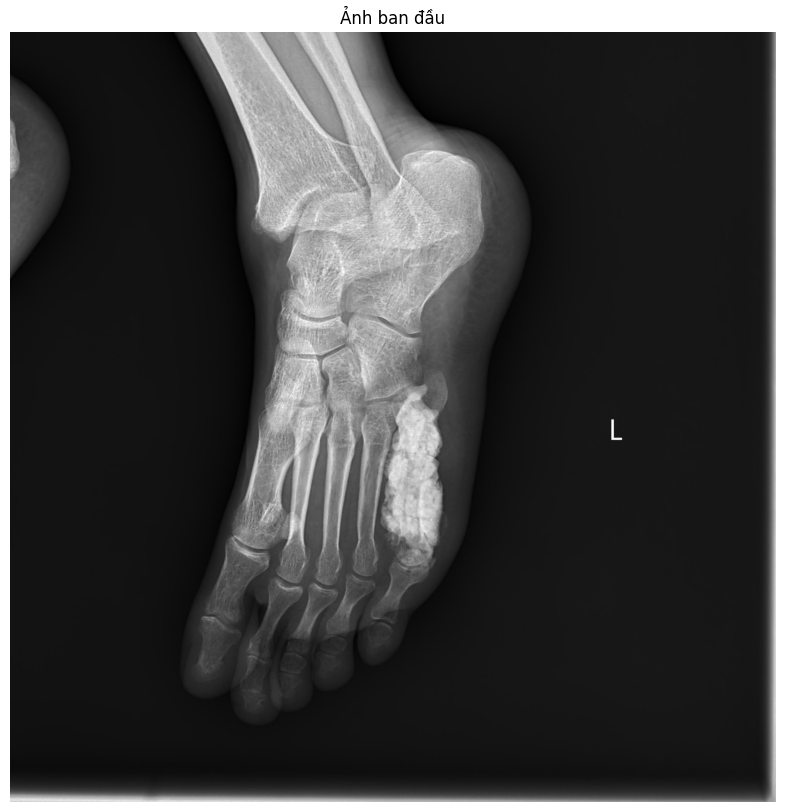

In [13]:
# Đọc file JSON
with open(path+"Annotations/IMG000005.json", "r") as f:
    data = json.load(f)

# Lấy đường dẫn ảnh
image_path = path +'images/'+ data.get("imagePath", None)
print (image_path)
# Kiểm tra và đọc ảnh
if image_path and os.path.exists(image_path):  
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB để hiển thị đúng màu
else:
    print(f"⚠️ Không tìm thấy ảnh tại tạo nền trắng.")
    img = np.ones((data["imageHeight"], data["imageWidth"], 3), dtype=np.uint8) * 255  

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Ảnh ban đầu")
plt.axis("off")
plt.show()

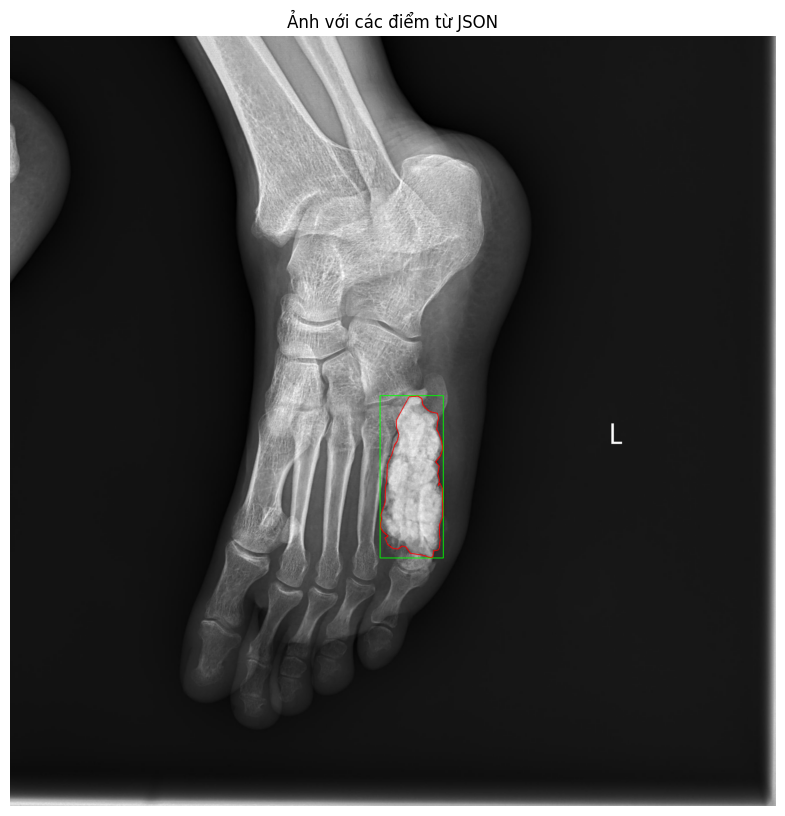

In [14]:
# Vẽ các điểm từ JSON
for shape in data["shapes"]:
    points = np.array(shape["points"], dtype=np.int32)  # Chuyển về kiểu số nguyên
    label = shape["label"]
    
    # Kiểm tra loại hình dạng
    if shape["shape_type"] == "polygon":
        cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
    elif shape["shape_type"] == "rectangle":
        cv2.rectangle(img, tuple(points[0]), tuple(points[1]), (0, 255, 0), 2)

# Hiển thị ảnh
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Ảnh với các điểm từ JSON")
plt.axis("off")
plt.show()

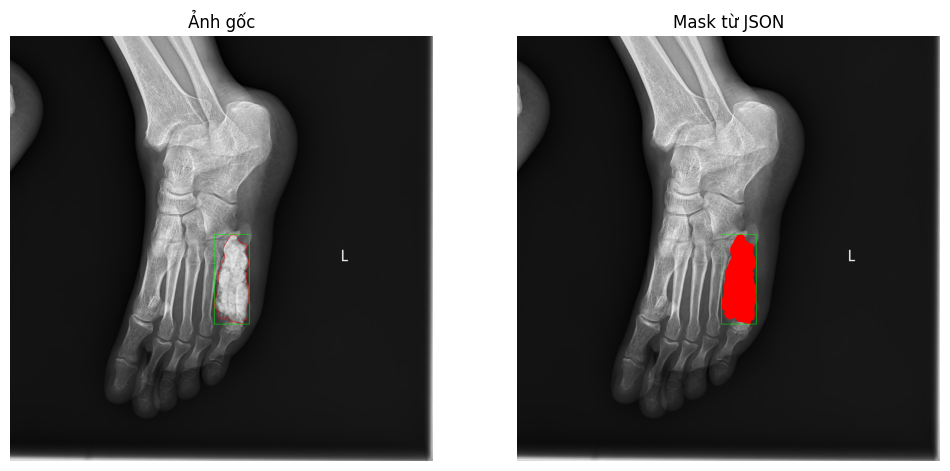

In [15]:
# Tạo mask (ảnh đen) cùng kích thước với ảnh gốc
mask = img.copy()

# Duyệt qua các hình trong JSON và vẽ lên mask
for shape in data["shapes"]:
    points = np.array(shape["points"], dtype=np.int32)  # Chuyển về numpy array

    if shape["shape_type"] == "polygon":
        cv2.fillPoly(mask, [points], color=(255))  # Đổ màu trắng vào mask

# Hiển thị ảnh gốc và mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask từ JSON")
plt.axis("off")
plt.show()

# **Vẽ đồ thị**

In [16]:
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))  # Sinh màu ngẫu nhiên

In [17]:
# Hàm vẽ biểu đồ tròn
def plot_pie_chart(df,column, title="Pie Chart"):
    
    counts= df[column].value_counts(normalize=True)*100
    colors = [random_color() for _ in range(len(counts))] 
    
    plt.figure(figsize=(8,8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', 
            startangle=140, colors=colors)

     # Tiêu đề biểu đồ
    plt.title(title, fontsize=14, fontweight='bold')

    # Hiển thị biểu đồ
    plt.show()

In [18]:
df_filtered = df[df["neoplasm"] != "no tumor"]

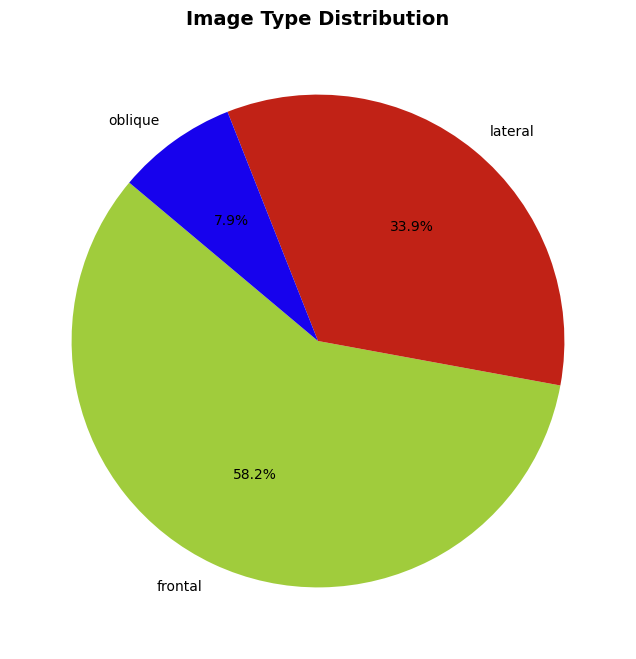

In [19]:
#biểu đồ tròn thể hiện phần trăm ảnh được chụp theo các hướng
plot_pie_chart(df, "img_type", "Image Type Distribution")

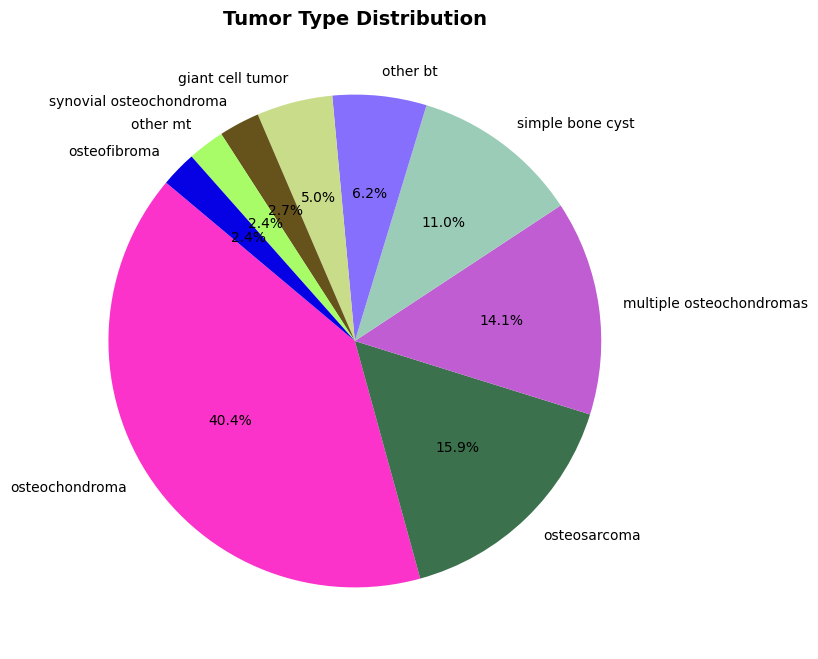

In [20]:
#biểu đồ tròn thể hiện tỉ lệ các loại ung thư
plot_pie_chart(df, "tumor_type", "Tumor Type Distribution")

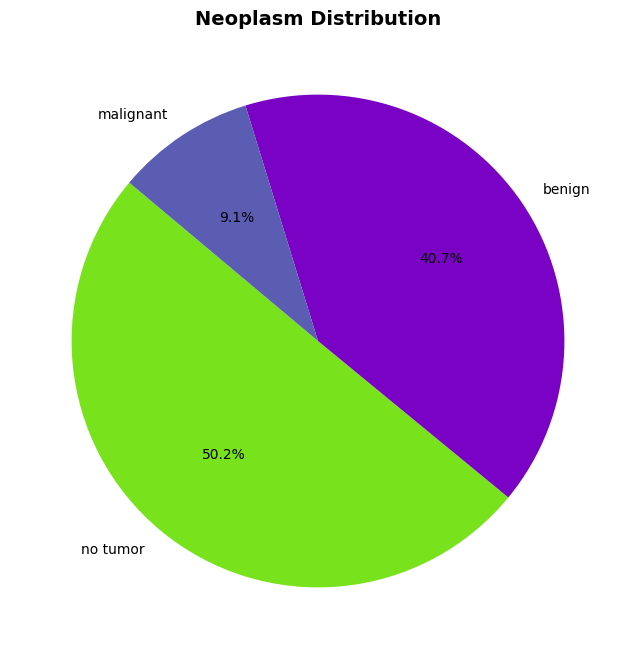

In [21]:
#biểu đồ tròn thể hiện tỉ lệ ung thư
plot_pie_chart(df, "neoplasm", "Neoplasm Distribution")

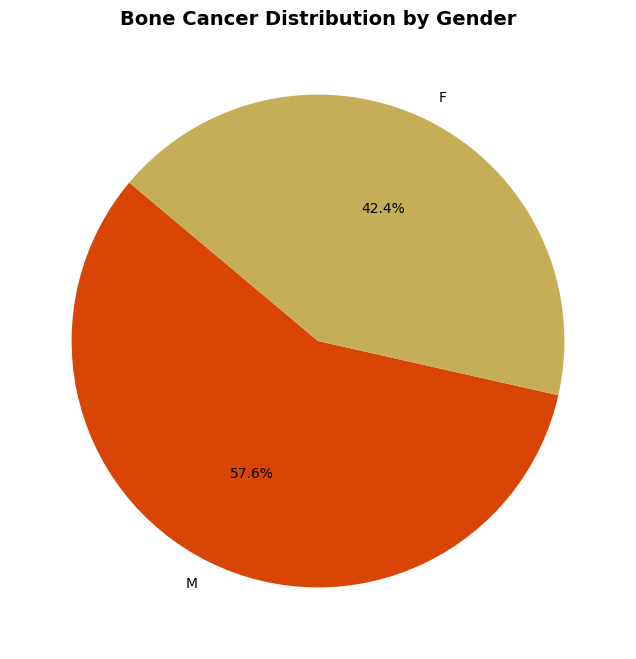

In [22]:
plot_pie_chart(df_filtered, "gender", "Bone Cancer Distribution by Gender")

In [23]:
def line_chart(column1, column2,labelx="xyz",labely="abc",  title="Pie Chart"):
    plt.figure(figsize=(8, 5))  # Định kích thước biểu đồ
    plt.plot(column1, column2, marker='o', linestyle='-', color='blue')

    # Định dạng biểu đồ
    plt.xlabel(labelx, fontsize=12)
    plt.ylabel(labely, fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.xticks(rotation=45)  # Xoay nhãn trục x nếu cần
    plt.show() 

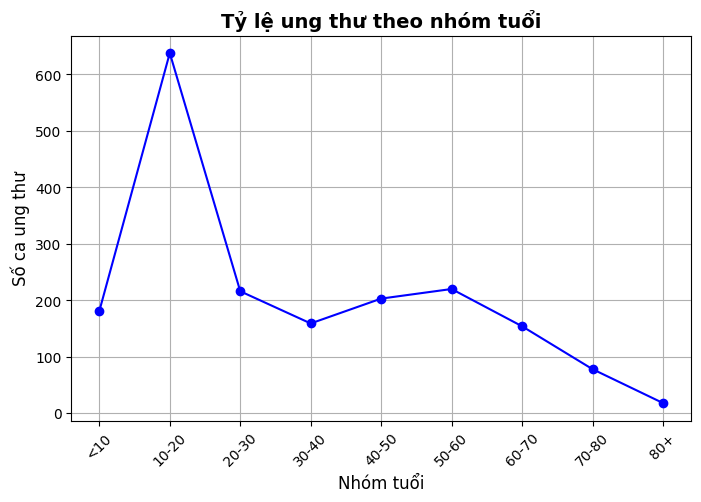

In [24]:
# Lọc chỉ những bệnh nhân bị ung thư
df_cancer = df[df["tumor"] == 1].copy()

# Chia nhóm tuổi
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
labels = ["<10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
df_cancer["Age Group"] = pd.cut(df_cancer["age"], bins=bins, labels=labels, right=False)

# Đếm số ca ung thư theo nhóm tuổi
cancer_counts = df_cancer["Age Group"].value_counts().sort_index()

# Vẽ biểu đồ đường
# Chuyển index về dạng chuỗi để tránh lỗi khi vẽ biểu đồ
line_chart(cancer_counts.index.astype(str), cancer_counts.values, 
           labelx="Nhóm tuổi", labely="Số ca ung thư", 
           title="Tỷ lệ ung thư theo nhóm tuổi")

# **Vẽ table**

In [25]:
sheet_name = "Sheet2"

In [26]:
if os.path.exists(file_path):
    try:
        existing_data = pd.read_excel(file_path, sheet_name=sheet_name)
        startrow= len(existing_data) +1
        print(f"sheet_name tồn tại, bắt đầu từ hàng thứ {startrow}")
    except ValueError:
        startrow = 0
        print(f"{sheet_name} tồn tại, bắt đầu từ hàng 0")
else :
    startrow = 0
    print(f"{sheet_name} không tồn tại, tạo sheet mới, bắt đầu từ hàng 0")

gap_between_tables = 3

# Ghi vào Excel
def save_excel(data, file_path, sheet_name, title):
    global startrow
    
    title_df = pd.DataFrame([[title]])

    with pd.ExcelWriter(file_path, engine="openpyxl", mode="a",if_sheet_exists="overlay") as writer:
        title.to_excel(writer, sheet_name= sheet_name, startrow=startrow, index=False, header=False)
        # Ghi dữ liệu vào Sheet2
        data.to_excel(writer, sheet_name=sheet_name, startrow=startrow+2)
        
    startrow += len(data) + 2 + gap_between_tables
    
    print(f"✅ Đã cập nhật vào {sheet_name} của {file_path} thành công!")

Sheet2 tồn tại, bắt đầu từ hàng 0


In [27]:
# Tạo bảng thống kê theo neoplasm
tumor_summary_byneoplasm = pd.crosstab(df["tumor_type"], df["neoplasm"])
print(tumor_summary_byneoplasm)

# Để tên bảng
title_df = pd.DataFrame([["Bảng thống kê số lượng khối u lành tính và ác tính trong từng loại ung thư"]])

#lưu vào excel
save_excel(tumor_summary_byneoplasm,file_path, sheet_name,title_df )

neoplasm                  benign  malignant
tumor_type                                 
giant cell tumor              93          0
multiple osteochondromas     263          0
osteochondroma               754          0
osteofibroma                  44          0
osteosarcoma                   0        297
other bt                     115          0
other mt                       0         45
simple bone cyst             206          0
synovial osteochondroma       50          0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [28]:
# Tạo bảng thống kê theo img_type
tumor_summary_byimg = pd.crosstab(df["tumor_type"], df["img_type"])
print(tumor_summary_byimg)

# Tiêu đề cho bảng
title_df = pd.DataFrame([["Bảng phân bố số lượng ung thư theo hướng chụp"]])

#lưu vào excel
save_excel(tumor_summary_byimg,file_path, sheet_name,title_df )

img_type                  frontal  lateral  oblique
tumor_type                                         
giant cell tumor               55       34        4
multiple osteochondromas      162       97        4
osteochondroma                493      223       38
osteofibroma                   25       18        1
osteosarcoma                  187       89       21
other bt                       67       42        6
other mt                       30       12        3
simple bone cyst              136       43       27
synovial osteochondroma        24       23        3
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [29]:
bins=[0,20,40,60,80,100]

labels = ["0-20", "21-40", "41-60", "61-80", "81-100"]

df['age_group']=pd.cut(df["age"], bins=bins, labels=labels, right=False)

tumor_summary_byagegroups=pd.crosstab(df['tumor_type'], df['age_group'])
print(tumor_summary_byagegroups)

title_df=pd.DataFrame([["Bảng thống kê ung thư theo nhóm tuổi"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

age_group                 0-20  21-40  41-60  61-80  81-100
tumor_type                                                 
giant cell tumor            12     54     10     13       4
multiple osteochondromas   204     27     27      4       1
osteochondroma             243    154    246    107       4
osteofibroma                31      8      2      3       0
osteosarcoma               161     45     43     45       3
other bt                    28     41     34     11       1
other mt                    14     13     13      5       0
simple bone cyst           123     29     31     18       5
synovial osteochondroma      3      4     17     26       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [30]:
tumor_summary_bygender=pd.crosstab(df['tumor_type'], df['gender'])
print(tumor_summary_bygender)

tif=pd.DataFrame([["Thống kê số lượng ưng thư theo giới tính"]])
save_excel(tumor_summary_bygender,file_path, sheet_name,tif )

gender                      F    M
tumor_type                        
giant cell tumor           42   51
multiple osteochondromas  120  143
osteochondroma            309  445
osteofibroma               16   28
osteosarcoma              138  159
other bt                   38   77
other mt                   24   21
simple bone cyst           78  128
synovial osteochondroma    27   23
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [31]:
# Lọc bệnh nhân nữ
female_df = df[df["gender"] == "F"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(female_df["tumor_type"], female_df["age_group"])

# In kết quả
print(tumor_summary_byagegender)

tif=pd.DataFrame([["Thống kê số ca ung thư ở nữ theo nhóm tuổi"]])
save_excel(tumor_summary_byagegender,file_path, sheet_name,tif )

age_group                 0-20  21-40  41-60  61-80  81-100
tumor_type                                                 
giant cell tumor             8     23      3      8       0
multiple osteochondromas    82     16     18      4       0
osteochondroma              76     68    107     57       1
osteofibroma                11      0      2      3       0
osteosarcoma                80     22     21     15       0
other bt                     8      8     16      5       1
other mt                     9      8      3      4       0
simple bone cyst            49     14      9      5       1
synovial osteochondroma      2      0      8     17       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [32]:
# Lọc bệnh nhân nữ
female_df = df[df["gender"] == "F"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(female_df["neoplasm"], female_df["age_group"])

# In kết quả
print(tumor_summary_byagegender)

tif=pd.DataFrame([["Thống kê số lượng ca ung thư lành tính ác tính theo độ tuổi của nữ"]])
save_excel(tumor_summary_byagegender,file_path, sheet_name,tif )

age_group  0-20  21-40  41-60  61-80  81-100
neoplasm                                    
benign      236    129    163     99       3
malignant    89     30     24     19       0
no tumor    152    227    313    143      21
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [33]:
# Lọc bệnh nhân nữ
male_df = df[df["gender"] == "M"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(male_df["tumor_type"], male_df["age_group"])

# In kết quả
print(tumor_summary_byagegender)

tif=pd.DataFrame([["Thống kê số ca ung thư ở nam theo nhóm tuổi"]])
save_excel(tumor_summary_byagegender,file_path, sheet_name,tif )

age_group                 0-20  21-40  41-60  61-80  81-100
tumor_type                                                 
giant cell tumor             4     31      7      5       4
multiple osteochondromas   122     11      9      0       1
osteochondroma             167     86    139     50       3
osteofibroma                20      8      0      0       0
osteosarcoma                81     23     22     30       3
other bt                    20     33     18      6       0
other mt                     5      5     10      1       0
simple bone cyst            74     15     22     13       4
synovial osteochondroma      1      4      9      9       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [34]:
# Lọc bệnh nhân nam
male_df = df[df["gender"] == "M"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(male_df["neoplasm"], male_df["age_group"])

# In kết quả
print(tumor_summary_byagegender)

tif=pd.DataFrame([["Thống kê số lượng ca ung thư lành tính ác tính theo độ tuổi của nam"]])
save_excel(tumor_summary_byagegender,file_path, sheet_name,tif )

age_group  0-20  21-40  41-60  61-80  81-100
neoplasm                                    
benign      408    188    204     83      12
malignant    86     28     32     31       3
no tumor    231    318    361     98      15
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [35]:
# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byvitri = pd.crosstab(df["tumor_type"], df["skeletal_type"])

# In kết quả
print(tumor_summary_byvitri)

tif=pd.DataFrame([["Thống kê số ca ung thư theo vùng xương"]])
save_excel(tumor_summary_byvitri,file_path, sheet_name,tif )

skeletal_type             lower limb  pelvis  upper limb
tumor_type                                              
giant cell tumor                  52       8          33
multiple osteochondromas         194       7          62
osteochondroma                   599      16         139
osteofibroma                      39       0           5
osteosarcoma                     205      22          70
other bt                          74      14          27
other mt                          25      10          10
simple bone cyst                  85      24          97
synovial osteochondroma           38       3           9
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [36]:
bins=[0,1,2,3,4,5]

labels = ["<1%", "1-2%", "2-3%", "3-5%", ">5%"]

df['spread']=pd.cut(df["tumor_ratio"], bins=bins, labels=labels, right=False)

tumor_summary_byarea=pd.crosstab(df["tumor_type"], df["spread"])
print(tumor_summary_byarea)

tif=pd.DataFrame([["Thống kê số ca ung thư theo mức độ lan rộng của khối u"]])
save_excel(tumor_summary_byarea,file_path, sheet_name,tif )

spread                    <1%  1-2%  2-3%  3-5%  >5%
tumor_type                                          
giant cell tumor           16    24    19    10    5
multiple osteochondromas   51    32    27    27   22
osteochondroma            656    64    21     7    2
osteofibroma               39     5     0     0    0
osteosarcoma               19    65    58    35   33
other bt                   69    28     8     3    1
other mt                   11     9     6     5    3
simple bone cyst           98    49    23     9    9
synovial osteochondroma     6     3     6     2    3
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [37]:
bins=[0,20,40,60,80,100]

labels = ["0-20", "21-40", "41-60", "61-80", "81-100"]

df['age_group']=pd.cut(df["age"], bins=bins, labels=labels, right=False)

tumor_summary_byagegroups=pd.crosstab(df['neoplasm'], df['age_group'])
print(tumor_summary_byagegroups)

title_df=pd.DataFrame([["Bảng thống kê số lượng khối u lành tính ác tính theo độ tuổi"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

age_group  0-20  21-40  41-60  61-80  81-100
neoplasm                                    
benign      644    317    367    182      15
malignant   175     58     56     50       3
no tumor    383    545    674    241      36
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [38]:
tumor_summary_byagegroups=pd.crosstab(df['bones_type'], df['age_group'])
print(tumor_summary_byagegroups)

title_df=pd.DataFrame([["Bảng thống kê vị trí chụp khối u theo độ tuổi"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

age_group       0-20  21-40  41-60  61-80  81-100
bones_type                                       
ankle-joint        0      0      3      0       0
elbow-joint        1      0      4      0       0
femur            219    111     93     49       5
fibula            38     27     41     20       1
foot              26     27     24     16       0
hand              22     23     41      8       3
hip bone          10      8     15     17       5
humerus          139     32     34     25       0
no img           383    549    682    268      36
radius            26      8      6      9       0
shoulder-joint     2      0      4      2       0
tibia            295    131    142     52       4
ulna              41      4      8      7       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [39]:
tumor_summary_byagegroups=pd.crosstab(df['bones_type'], df['gender'])
print(tumor_summary_byagegroups)

title_df=pd.DataFrame([["Bảng thống kê vị trí chụp khối u theo giới tính"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

gender            F     M
bones_type               
ankle-joint       0     3
elbow-joint       4     1
femur           195   282
fibula           52    75
foot             30    63
hand             40    57
hip bone         19    36
humerus          87   143
no img          877  1041
radius           20    29
shoulder-joint    3     5
tibia           291   333
ulna             30    30
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [40]:
# Lọc bệnh nhân nam
male_df = df[df["gender"] == "M"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(male_df["tumor_type"], male_df["age_group"])
print(tumor_summary_byagegender)

title_df=pd.DataFrame([["Bảng thống kê của nam giới theo độ tuổi"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

age_group                 0-20  21-40  41-60  61-80  81-100
tumor_type                                                 
giant cell tumor             4     31      7      5       4
multiple osteochondromas   122     11      9      0       1
osteochondroma             167     86    139     50       3
osteofibroma                20      8      0      0       0
osteosarcoma                81     23     22     30       3
other bt                    20     33     18      6       0
other mt                     5      5     10      1       0
simple bone cyst            74     15     22     13       4
synovial osteochondroma      1      4      9      9       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!


In [41]:
# Lọc bệnh nhân nam
male_df = df[df["gender"] == "F"]

# Tạo bảng thống kê số lượng nữ bị ung thư theo độ tuổi
tumor_summary_byagegender = pd.crosstab(male_df["tumor_type"], male_df["age_group"])
print(tumor_summary_byagegender)

title_df=pd.DataFrame([["Bảng thống kê của nữ giới theo độ tuổi"]])
save_excel(tumor_summary_byagegroups,file_path, sheet_name,title_df )

age_group                 0-20  21-40  41-60  61-80  81-100
tumor_type                                                 
giant cell tumor             8     23      3      8       0
multiple osteochondromas    82     16     18      4       0
osteochondroma              76     68    107     57       1
osteofibroma                11      0      2      3       0
osteosarcoma                80     22     21     15       0
other bt                     8      8     16      5       1
other mt                     9      8      3      4       0
simple bone cyst            49     14      9      5       1
synovial osteochondroma      2      0      8     17       0
✅ Đã cập nhật vào Sheet2 của classification.xlsx thành công!
